<Axes: title={'center': 'Bitcoin Close Price'}, xlabel='Timestamp'>

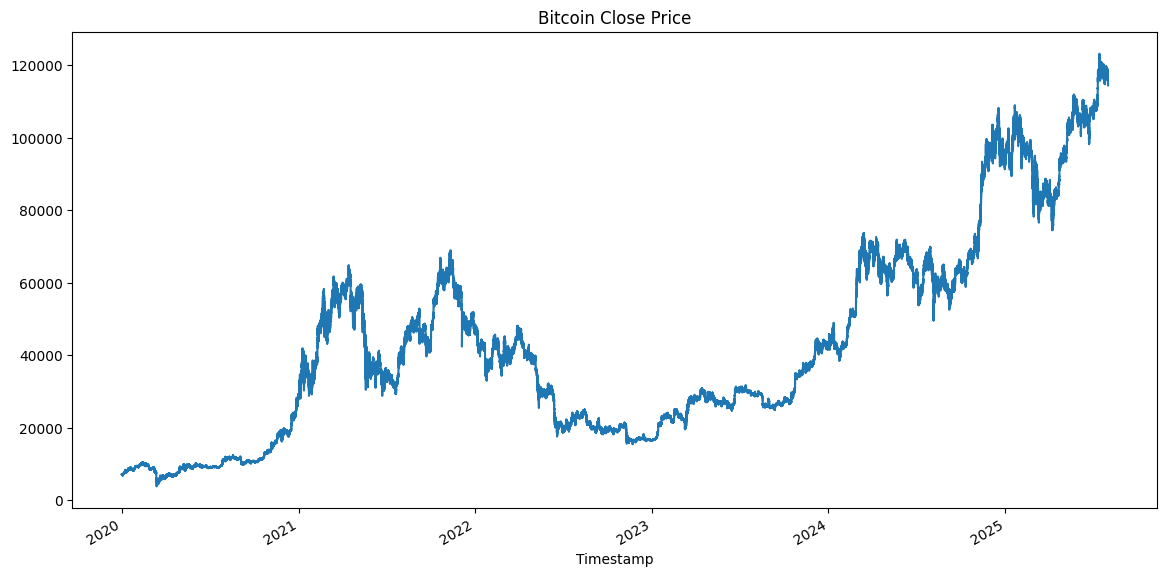

In [1]:
# import pandas as pd
# from datetime import datetime
# bitstamp = pd.read_csv("btcusd_1-min_data.csv")
# bitstamp.info()
# bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
# bitstamp.set_index('Timestamp', inplace=True)
# bitstamp.tail()
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src"))
from preprocessing import *

# Load the data
bitstamp = dataload()

# Filter the data from 2020-01-01 to the last date available
bitstamp = data_filter(bitstamp, '2020-01-01', bitstamp.index[-1])

# Plotting the Close price
bitstamp.Close.plot(figsize=(14,7), title="Bitcoin Close Price")

Missing values in the dataset:
Missing timestamps: 1160
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


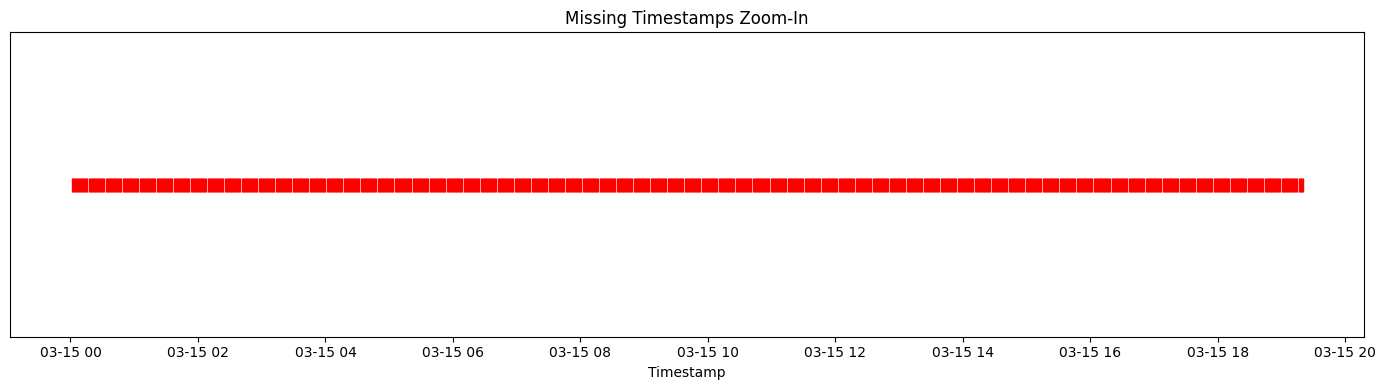

In [2]:
#calculating missing values in the dataset
import matplotlib.pyplot as plt

# find missing values by checking for NaN values
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

# display the missing values
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

# Plotting the missing timestamps
missing_df = pd.DataFrame(index=missing_times)
missing_df['Missing'] = 1
plt.figure(figsize=(14, 4))
plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
plt.title("Missing Timestamps Zoom-In")
plt.xlabel("Timestamp")
plt.yticks([]) 
plt.tight_layout()
plt.show()

g:\ML\Project\src\preprocessing.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method=method)


Missing values in the dataset:
Missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='min')
                         Open      High       Low     Close    Volume
Timestamp                                                            
2025-08-01 00:55:00  115031.0  115180.0  115031.0  115077.0  4.551279
2025-08-01 00:56:00  115107.0  115258.0  115107.0  115258.0  4.916915
2025-08-01 00:57:00  115258.0  115271.0  115209.0  115271.0  0.950385
2025-08-01 00:58:00  115271.0  115410.0  115271.0  115410.0  5.030814
2025-08-01 00:59:00  115410.0  115464.0  115409.0  115425.0  2.373751


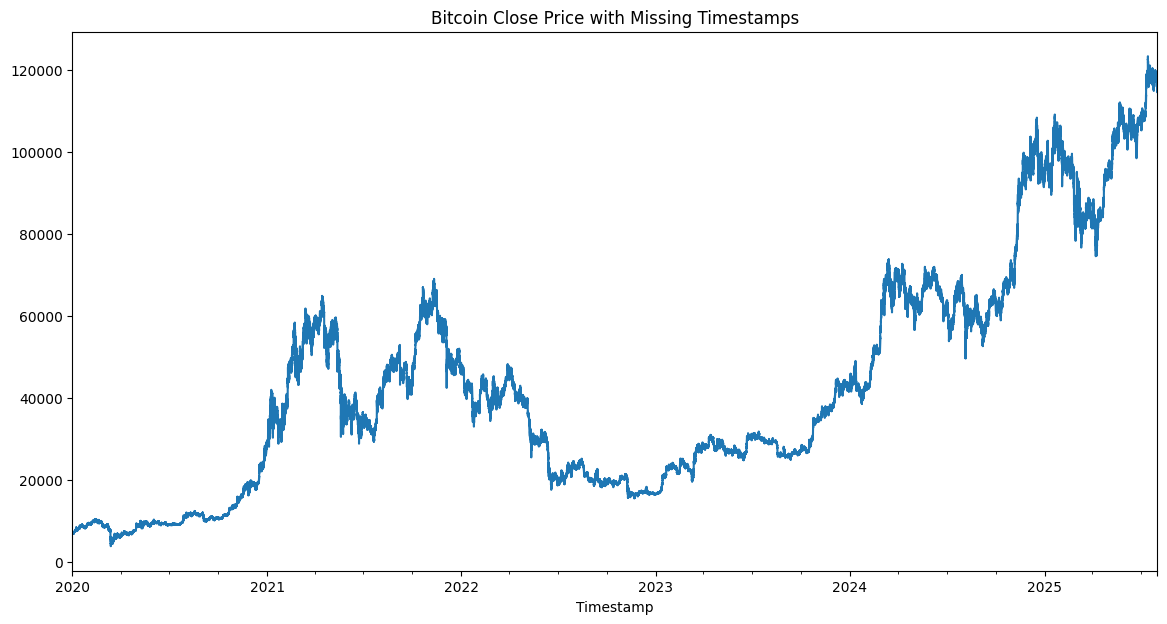

In [3]:

bitstamp_full = add_missing_timestamps(bitstamp, freq='1min')
# Plotting the Close price with missing timestamps
bitstamp_full['Close'].plot(figsize=(14, 7), title="Bitcoin Close Price with Missing Timestamps")

# using forward fill to fill the missing values
bitstamp_filled = fill_missing_values(bitstamp_full, method='ffill')

# display the missing values after filling
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp_filled.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])
print(bitstamp_filled.tail())

<Figure size 1200x900 with 0 Axes>

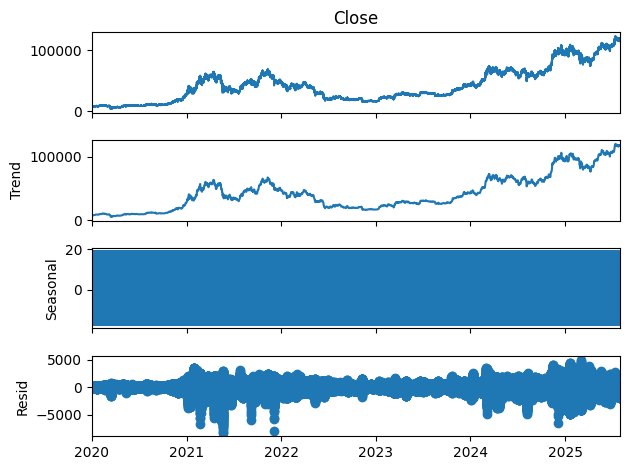

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = bitstamp_filled['Close'].copy()

ts = ts.resample('1min').mean() 

decomp_result = seasonal_decompose(ts, model='additive', period=1440)  

trend = decomp_result.trend
seasonal = decomp_result.seasonal
residual = decomp_result.resid

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
decomp_result.plot()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df = bitstamp_filled.copy()
features = df[['Close', 'Volume']]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)


scaled_df = pd.DataFrame(scaled_features, columns=['Close_scaled', 'Volume_scaled'], index=df.index)
df[['Close_scaled', 'Volume_scaled']] = scaled_df


                     Close_scaled  Volume_scaled
Timestamp                                       
2020-01-01 00:00:00      0.027470       0.000256
2020-01-01 00:01:00      0.027382       0.000034
2020-01-01 00:02:00      0.027412       0.000415
2020-01-01 00:03:00      0.027355       0.000060
2020-01-01 00:04:00      0.027355       0.000000


In [ ]:
import numpy as np

def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])  
        y.append(data[i + window_size, 0])    
    return np.array(X), np.array(y)


scaled_data = df[['Close_scaled', 'Volume_scaled']].values

X, y = create_sequences(scaled_data, window_size=24)

print(X.shape)  # 例如：(n_samples, 24, 2)
print(y.shape)  # 例如：(n_samples,)


split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(24, 2)))  
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mse')
model.summary()


model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


(2936196, 24, 2)
(2936196,)


c:\Users\jiang\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
58724/58724 ━━━━━━━━━━━━━━━━━━━━ 149s 3ms/step - loss: 7.1721e-05 - val_loss: 9.7385e-08
Epoch 2/20
58724/58724 ━━━━━━━━━━━━━━━━━━━━ 153s 3ms/step - loss: 2.6889e-07 - val_loss: 5.6210e-06
Epoch 3/20
58724/58724 ━━━━━━━━━━━━━━━━━━━━ 166s 3ms/step - loss: 2.1764e-07 - val_loss: 1.0186e-06
Epoch 4/20
53822/58724 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.9803e-07

KeyboardInterrupt: 

# Add time feature

In [ ]:
# Extracting time features from the index

df['year'] = df.index.year
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
print(df[['year', 'hour', 'dayofweek', 'day', 'month', 'is_weekend']].tail(100))



                     year  hour  dayofweek  day  month  is_weekend
Timestamp                                                         
2025-07-31 23:20:00  2025    23          3   31      7           0
2025-07-31 23:21:00  2025    23          3   31      7           0
2025-07-31 23:22:00  2025    23          3   31      7           0
2025-07-31 23:23:00  2025    23          3   31      7           0
2025-07-31 23:24:00  2025    23          3   31      7           0
...                   ...   ...        ...  ...    ...         ...
2025-08-01 00:55:00  2025     0          4    1      8           0
2025-08-01 00:56:00  2025     0          4    1      8           0
2025-08-01 00:57:00  2025     0          4    1      8           0
2025-08-01 00:58:00  2025     0          4    1      8           0
2025-08-01 00:59:00  2025     0          4    1      8           0

[100 rows x 6 columns]


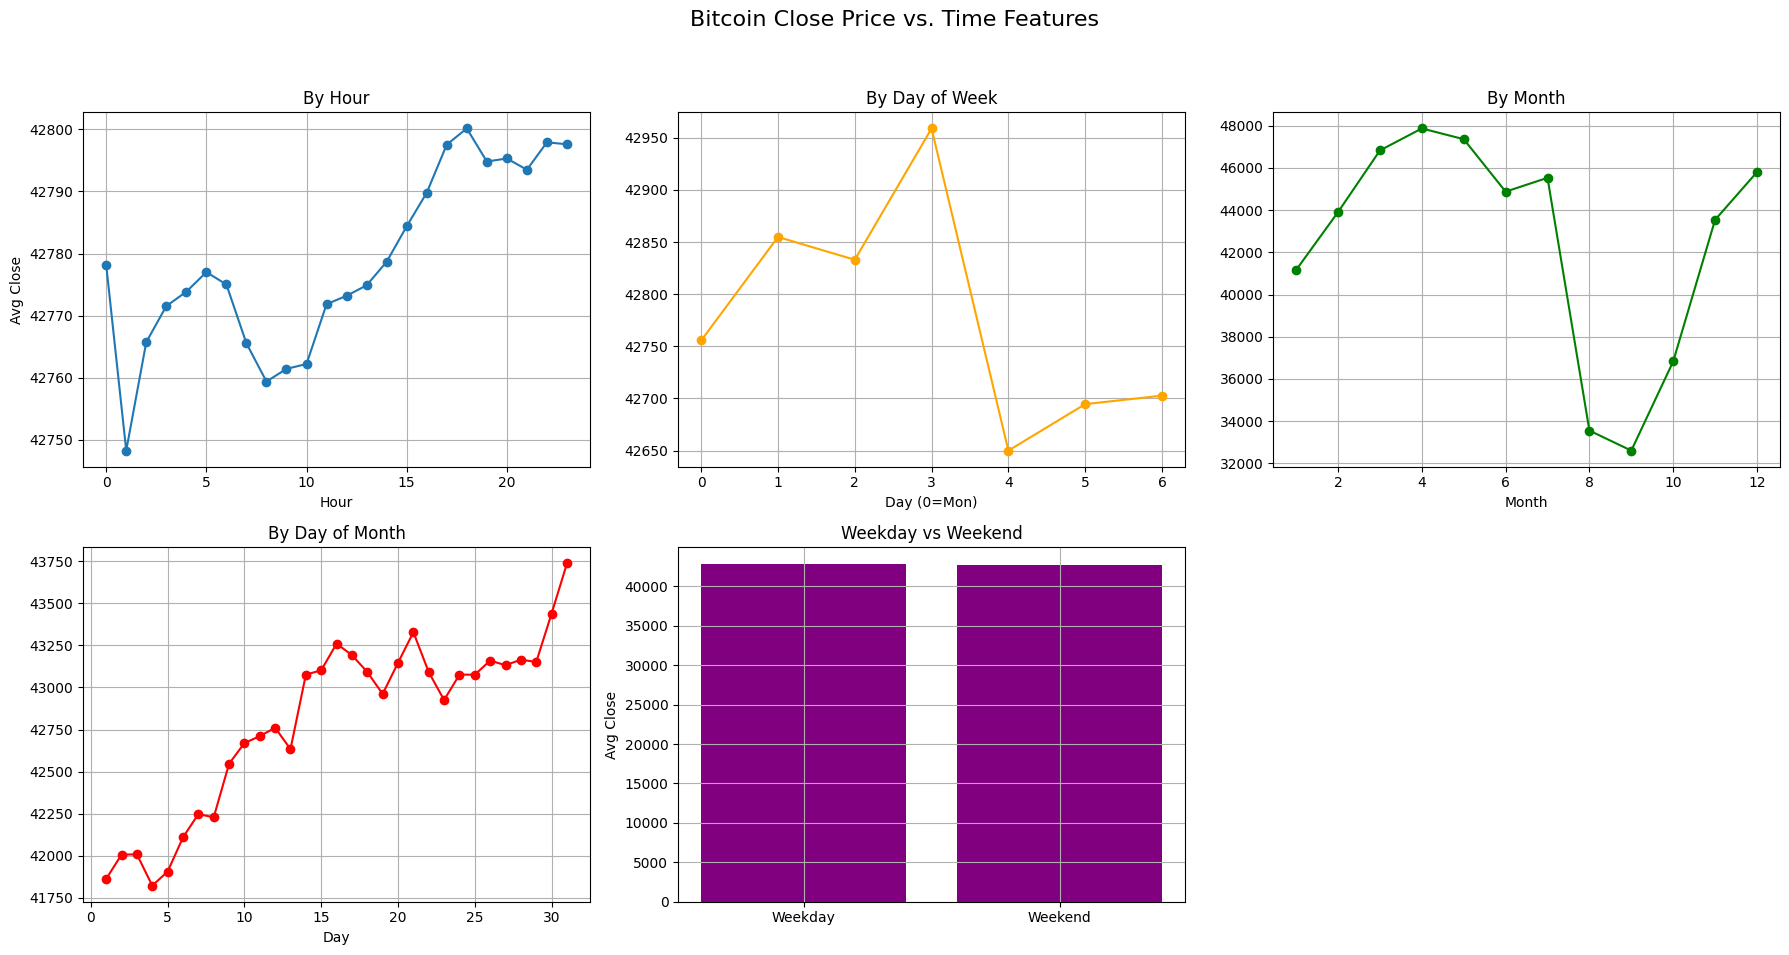

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 总共 6 个图
fig.suptitle("Bitcoin Close Price vs. Time Features", fontsize=16)

# Hour
hour_avg = df.groupby('hour')['Close'].mean()
axes[0, 0].plot(hour_avg, marker='o')
axes[0, 0].set_title('By Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Avg Close')
axes[0, 0].grid(True)

# Day of Week
dow_avg = df.groupby('dayofweek')['Close'].mean()
axes[0, 1].plot(dow_avg, marker='o', color='orange')
axes[0, 1].set_title('By Day of Week')
axes[0, 1].set_xlabel('Day (0=Mon)')
axes[0, 1].grid(True)

# Month
month_avg = df.groupby('month')['Close'].mean()
axes[0, 2].plot(month_avg, marker='o', color='green')
axes[0, 2].set_title('By Month')
axes[0, 2].set_xlabel('Month')
axes[0, 2].grid(True)

# Day of Month
day_avg = df.groupby('day')['Close'].mean()
axes[1, 0].plot(day_avg, marker='o', color='red')
axes[1, 0].set_title('By Day of Month')
axes[1, 0].set_xlabel('Day')
axes[1, 0].grid(True)

# Is Weekend
weekend_avg = df.groupby('is_weekend')['Close'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_avg.values, color='purple')
axes[1, 1].set_title('Weekday vs Weekend')
axes[1, 1].set_ylabel('Avg Close')
axes[1, 1].grid(True)


axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

count    2.936220e+06
mean     2.385076e-16
std      1.000000e+00
min     -1.397077e+00
25%     -7.881414e-01
50%     -2.019005e-01
75%      6.253166e-01
max      2.888576e+00
Name: close_z_global, dtype: float64
hour
0    -1.718126e-05
1    -1.090465e-03
2    -4.638170e-04
3    -2.555406e-04
4    -1.723894e-04
5    -5.918896e-05
6    -1.304431e-04
7    -4.707638e-04
8    -6.912455e-04
9    -6.180280e-04
10   -5.900069e-04
11   -2.442018e-04
12   -1.959244e-04
13   -1.353177e-04
14    6.913029e-07
15    2.056139e-04
16    3.993966e-04
17    6.774929e-04
18    7.710530e-04
19    5.799779e-04
20    5.975039e-04
21    5.323520e-04
22    6.907842e-04
23    6.796568e-04
Name: close_z_global, dtype: float64


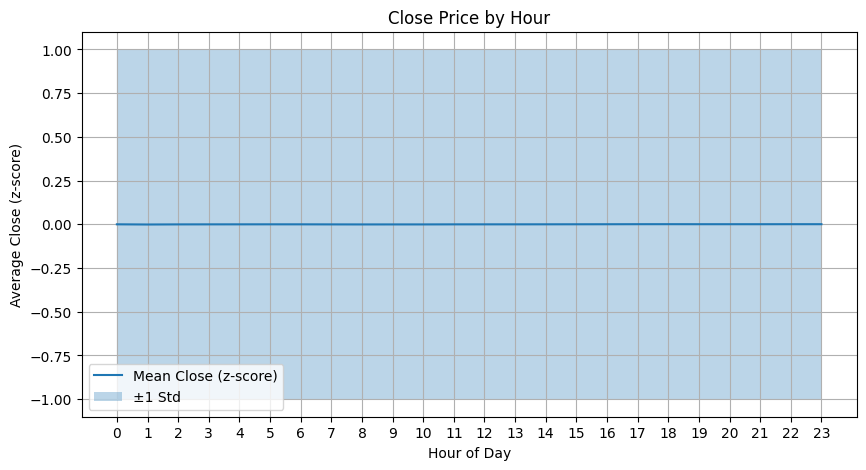

In [ ]:
import matplotlib.pyplot as plt

df['date'] = df.index.date 
df['close_z'] = df.groupby('date')['Close'].transform(lambda x: (x - x.mean()) / x.std())
global_mean = df['Close'].mean()
global_std = df['Close'].std()
df['close_z_global'] = (df['Close'] - global_mean) / global_std

hour_stats = df.groupby('hour')['close_z_global'].agg(['mean', 'std'])

hour_stats['upper'] = hour_stats['mean'] + hour_stats['std']
hour_stats['lower'] = hour_stats['mean'] - hour_stats['std']
print(df['close_z_global'].describe())
print(df.groupby('hour')['close_z_global'].mean())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(hour_stats.index, hour_stats['mean'], label='Mean Close (z-score)')
plt.fill_between(hour_stats.index, hour_stats['lower'], hour_stats['upper'], alpha=0.3, label='±1 Std')
plt.title("Close Price by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Close (z-score)")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.show()

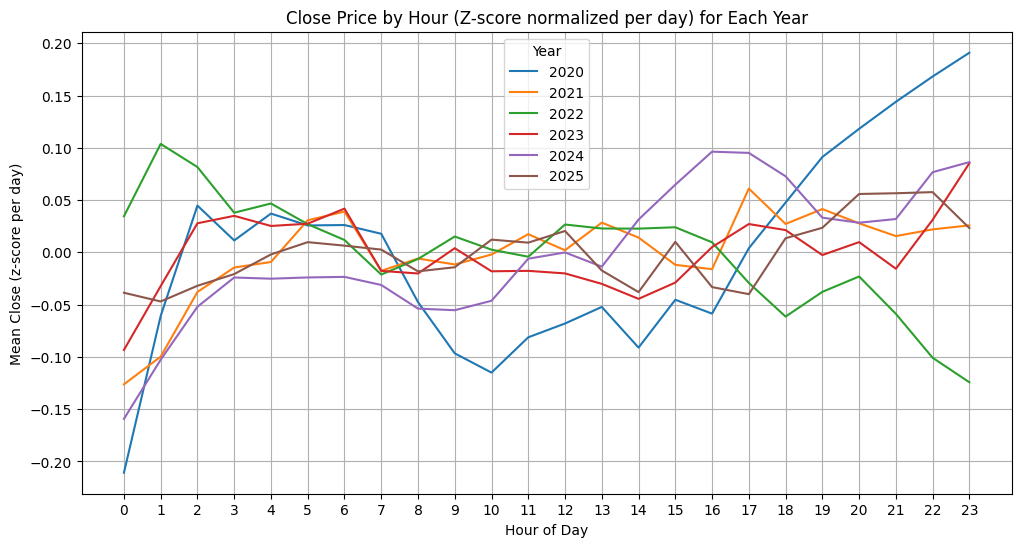

In [27]:
grouped = df.groupby(['year', 'hour'])['close_z'].mean().reset_index()

plt.figure(figsize=(12, 6))
for year in sorted(grouped['year'].unique()):
    subset = grouped[grouped['year'] == year]
    plt.plot(subset['hour'], subset['close_z'], label=f'{year}')

plt.title("Close Price by Hour (Z-score normalized per day) for Each Year")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Close (z-score per day)")
plt.grid(True)
plt.legend(title="Year")
plt.xticks(range(0, 24))
plt.show()

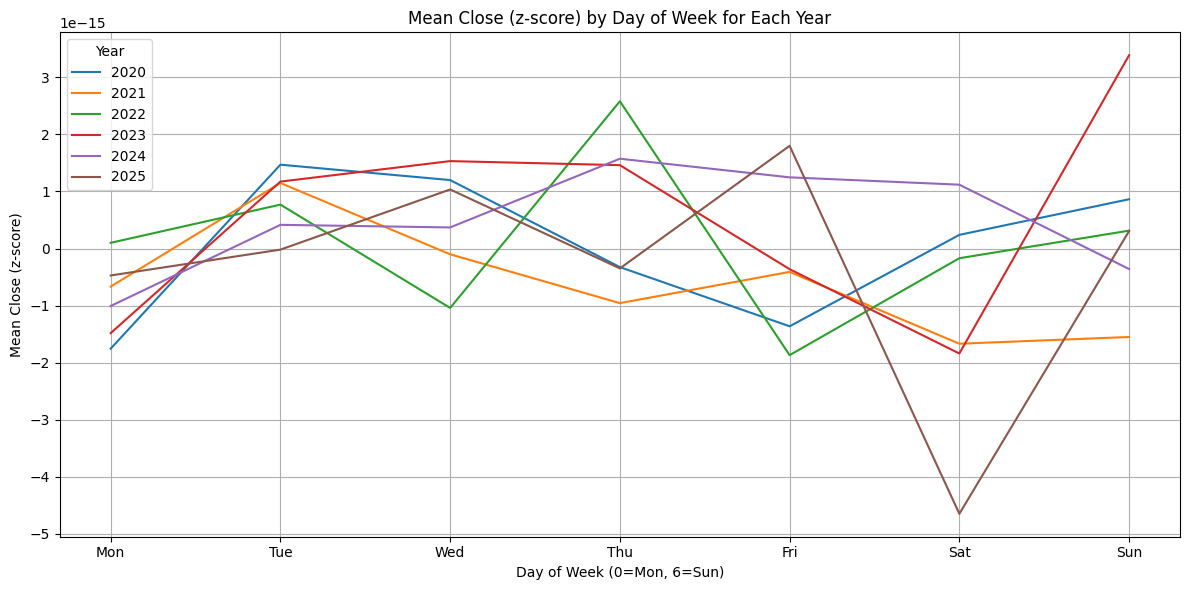

In [ ]:
dow_yearly = df.groupby(['year', 'dayofweek'])['close_z'].mean().unstack(level=0)


plt.figure(figsize=(12, 6))
for year in dow_yearly.columns:
    plt.plot(dow_yearly.index, dow_yearly[year], label=str(year))

plt.title("Mean Close (z-score) by Day of Week for Each Year")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Mean Close (z-score)")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))